# Synthetic data generator for asset networks and graph analysis
The code for this demostration is separated into a few files for readability:
1. the "main" file itself
2. data_gen2.py: for data generation 
3. graph_view.py: to display the graph in a browser tab
4. graph_exporter.py: to export the data into a graphml standart file
5. examples.py: where classes to solve the two example problems described below are defined

#### Notice:
1. This code is a demonstration, it is not optimized. By the contrary, it stores a lot of information that is intended for learning, debuging and experimenting in general. It uses a LOT of MEMORY. So, keep the number of nodes up to 20 or so. This will allow you to confirmed the analysis manualy, by inspection the displayed graph. Also noticed that memory is also hold in the Gremlin server.
2. if it does not run properly, it may be a memory problem. In a large or dense graphs, please set a limit of jumps between nodes as the number of orbits grows exponentially. It should not affect the result drasticaly, as each jump implies a multiplycation by a number between 0 and 1.(long paths contributions tend to vanish)
3. You NEED to CHANGE the absolute PATHS for the variables "data_file_name", "graph_file_name" to match your folder structure.


## Generating and displaying a random graph

In [10]:
# we start by setting the system parameters and the naming of the output files.
# here I will format the output in the graphML standard for datafiles and html for the visual graphics.
import os
import time
import string
from data_gen2 import AssetNetwork
from graph_view import GraphView
import graph_exporter as ge

N = 10  # number of nodes
conProb = 0.2 # the probability of a connection between two vertices to exist
nameLength = 2 # how long is each node random name. This may affect the size of the graph, as those names are unique.

# we are using time to create unique names for each experiment
time_stamp = time.strftime("%d-%H%M%S") 
data_file_name = "D:\\gitrepos\\assetnet\\datagen\data\\graph_"+time_stamp +".xml"
graph_file_name = "D:\\gitrepos\\assetnet\\datagen\data\\graph_"+time_stamp +".html"

# this step generates a random netwotk with approx N nodes and the probability of directed interconnections is conProb.
# An unique random name of length nameLengeh is associated to each node.
myGraph = AssetNetwork(N,conProb,nameLength)

number of nodes:  10  probability per connection:  0.2  names length:  2
List of assets(nodes):  ['DY', 'AG', 'TC', 'DB', 'BX', 'KU', 'FV', 'HH', 'UO', 'KH']
List of connections(edges):  [('DY', 'DB'), ('DY', 'KH'), ('AG', 'DB'), ('AG', 'FV'), ('DB', 'HH'), ('BX', 'KU'), ('BX', 'FV'), ('KU', 'DB'), ('KU', 'HH'), ('KU', 'UO'), ('FV', 'UO'), ('HH', 'FV'), ('UO', 'DY'), ('UO', 'KU'), ('KH', 'KU')]
Connections(edges) weights:  [0.06265972937688757, 1, 0.46386318260114867, 0.34662478751638626, 0.07314878265421465, 0.548873885542095, 0.5132127843068146, 0.47347708802196375, 0.9268512173457853, 0.44217808876480147, 0.5578219112351985, 0.14016242817679914, 1, 0.06385603643826665, 0.3872700780196383]


In [11]:
# this step will prepare a graph for display
myDisplay = GraphView(myGraph,graph_file_name)

#this will save the graph into an html file and display the result in a new tab
myDisplay.display()

# here we export our graph to a xml file in the graphml standard and display it in a new tab
ge.to_graphmlFile(myGraph,data_file_name)

D:\gitrepos\assetnet\datagen\data\graph_08-141225.html


## Connecting to the gremlin server
For the following to work, we need to have a gremlin server running with the right configuration. Please read the "SettingUp.txt" file before running this code.
The next cell will create a connection and a traversal with/from the gremlin server. These are the steps:
1. create a connection
2. create an empty graph
3. load our exported graph into Gremlin

In [12]:
# setup the connection to the Gremlin server
from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *

# python and Gremlin commands overlap in their naming. This library will provide the mapping to resolve that: search the library itself to find the right prefixed for each gremlin command, from the list imported bellow, e.g ID is T.id, within is P.within.
from gremlin_python.process.traversal import Barrier, Bindings, Cardinality, Column, Direction, Operator, Order, P, Pop, Scope, T, WithOptions

# Create a GraphTraversalSource which is the basis for all Gremlin traversals
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

#directly from python (not a notebook like jupter) do this
#g = traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin','g'))

#only for notebooks, to avoit "loop already running" error, do this:
from gremlin_python.driver.aiohttp.transport import AiohttpTransport

connection = DriverRemoteConnection('ws://localhost:8182/gremlin','g', transport_factory=lambda:AiohttpTransport(call_from_event_loop=True))
g = traversal().withRemote(connection)
g.V().drop().iterate()

#load our data to the server
g.io(data_file_name).read().iterate()

[['io', 'D:\\gitrepos\\assetnet\\datagen\\data\\graph_08-141225.xml'], ['read'], ['none'], ['values', '_ipython_canary_method_should_not_exist_'], ['values', '_ipython_canary_method_should_not_exist_']]

## Analysis of the graph
Now that we have the data loaded onto the Gremlin server, we can perform any queries using traversals.
We can also use the integration with python to manipulate and display the results of those queries. 

### Example 1
The random graphs generated above are compose of nodes, representing assets, and directed edges, representing which fraction of an asset is controlled/owned by the asset in the origin. In this example, we pose the question "Do an asset owns itself indirectly?And if so, how much in percentage"? Because this is basically a question about feedback loops in a graph, in a graph language, the query becomes intuitive. Even though it requires a few steps (under 100 lines), the algorithm takes care that all paths are all distict and direct. 

#### Analysis:

In [13]:
# create variables and run analysis: look inside examples.py for details
from examples import Example1

exp1 = Example1(g,myGraph)
exp1.runAnalysis()

all paths [[path[v[DY], v[KH], v[KU], v[UO]], path[v[DY], v[DB], v[HH], v[FV], v[UO]], path[v[DY], v[KH], v[KU], v[HH], v[FV], v[UO]], path[v[DY], v[KH], v[KU], v[DB], v[HH], v[FV], v[UO]]], [], [], [path[v[DB], v[HH], v[FV], v[UO], v[DY]], path[v[DB], v[HH], v[FV], v[UO], v[KU]]], [], [path[v[KU], v[UO]], path[v[KU], v[HH], v[FV], v[UO]], path[v[KU], v[DB], v[HH], v[FV], v[UO]]], [path[v[FV], v[UO], v[KU], v[HH]], path[v[FV], v[UO], v[DY], v[DB], v[HH]], path[v[FV], v[UO], v[KU], v[DB], v[HH]], path[v[FV], v[UO], v[DY], v[KH], v[KU], v[HH]], path[v[FV], v[UO], v[DY], v[KH], v[KU], v[DB], v[HH]]], [path[v[HH], v[FV], v[UO], v[KU]], path[v[HH], v[FV], v[UO], v[DY], v[DB]], path[v[HH], v[FV], v[UO], v[DY], v[KH], v[KU]]], [path[v[UO], v[KU]], path[v[UO], v[DY], v[KH], v[KU]], path[v[UO], v[DY], v[DB], v[HH], v[FV]]], [path[v[KH], v[KU], v[UO], v[DY]], path[v[KH], v[KU], v[HH], v[FV], v[UO], v[DY]], path[v[KH], v[KU], v[DB], v[HH], v[FV], v[UO], v[DY]]]] 

[[0.00035836269981119064, 0.1712

#### Display results:

<Figure size 700x700 with 0 Axes>

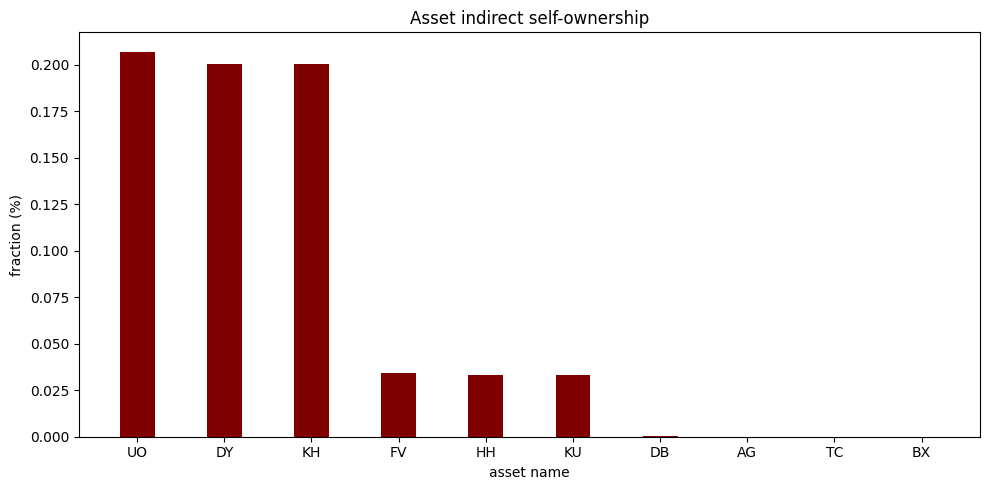

In [14]:
import numpy as np
import matplotlib.pyplot as plt
 
# prepar the data for plotting
data = {}
for i in range(len(myGraph.assetlist)):
    data[myGraph.assetlist[i]] = exp1.lista_fractio_perAsset[i]
sorted_data = dict(sorted(data.items(), key=lambda item: item[1],reverse=True))
    
assets = list(sorted_data.keys())
values = list(sorted_data.values())

#configure preferences
plt.figure(0)
fig = plt.figure(figsize = (10, 5)) 
plt.bar(assets, values, color ='maroon', width = 0.4)
 
plt.xlabel("asset name")
plt.ylabel("fraction (%)")
plt.title("Asset indirect self-ownership")
plt.show()

In [15]:
exp1.lista_paths

[[path[v[DY], v[KH], v[KU], v[UO]],
  path[v[DY], v[DB], v[HH], v[FV], v[UO]],
  path[v[DY], v[KH], v[KU], v[HH], v[FV], v[UO]],
  path[v[DY], v[KH], v[KU], v[DB], v[HH], v[FV], v[UO]]],
 [],
 [],
 [path[v[DB], v[HH], v[FV], v[UO], v[DY]],
  path[v[DB], v[HH], v[FV], v[UO], v[KU]]],
 [],
 [path[v[KU], v[UO]],
  path[v[KU], v[HH], v[FV], v[UO]],
  path[v[KU], v[DB], v[HH], v[FV], v[UO]]],
 [path[v[FV], v[UO], v[KU], v[HH]],
  path[v[FV], v[UO], v[DY], v[DB], v[HH]],
  path[v[FV], v[UO], v[KU], v[DB], v[HH]],
  path[v[FV], v[UO], v[DY], v[KH], v[KU], v[HH]],
  path[v[FV], v[UO], v[DY], v[KH], v[KU], v[DB], v[HH]]],
 [path[v[HH], v[FV], v[UO], v[KU]],
  path[v[HH], v[FV], v[UO], v[DY], v[DB]],
  path[v[HH], v[FV], v[UO], v[DY], v[KH], v[KU]]],
 [path[v[UO], v[KU]],
  path[v[UO], v[DY], v[KH], v[KU]],
  path[v[UO], v[DY], v[DB], v[HH], v[FV]]],
 [path[v[KH], v[KU], v[UO], v[DY]],
  path[v[KH], v[KU], v[HH], v[FV], v[UO], v[DY]],
  path[v[KH], v[KU], v[DB], v[HH], v[FV], v[UO], v[DY]]]]

### Example 2
The random graphs generated above are compose of nodes, representing assets, and directed edges, representing which fraction of an asset is controlled/owned by the asset in the origin. Given that the interdepence between nodes are encoded in the graph itself, how do nodes affect each other, directly and indirectly? 

In [16]:
from examples import Example2

exp2 = Example2(g,myGraph)
exp2_result_matrix = exp2.getInfluenceMatrix()

start example


<Figure size 700x700 with 0 Axes>

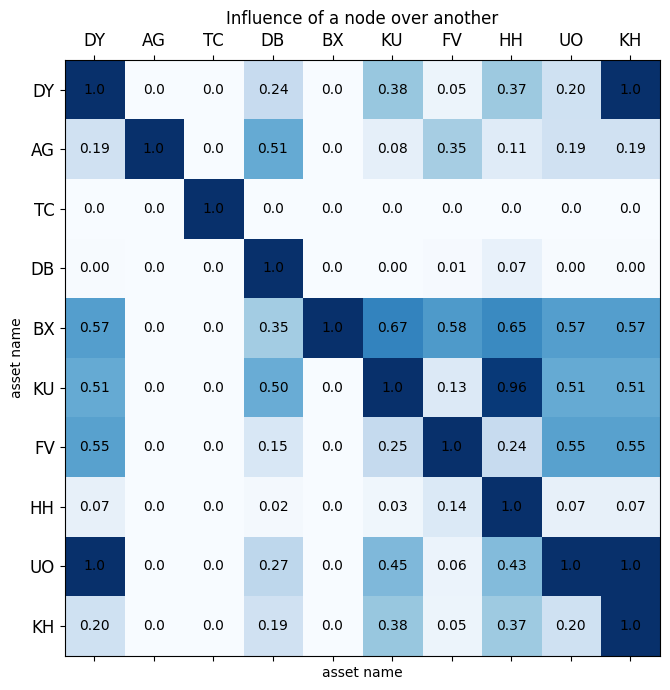

In [22]:
from matplotlib.ticker import MultipleLocator

plt.figure(1)

plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
min_val, max_val = len(myGraph.assetlist), len(myGraph.assetlist)
matrix = exp2_result_matrix

x = myGraph.assetlist
y = myGraph.assetlist
plt.xticks(range(len(x)), x, fontsize=12)
plt.yticks(range(len(y)), y, fontsize=12)

ax.matshow(matrix, cmap='Blues')
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(1))  

plt.xlabel("asset name")
plt.ylabel("asset name")
plt.title("Influence of a node over another")


for i in range(max_val):
   for j in range(max_val):
      c = matrix[j, i]
      ax.text(i, j, str(c)[0:4], va='center', ha='center')

plt.show()

In [18]:
# The connection should be closed on shut down to close open connections with connection.close()
#dealocate memory for the large objects and server
#del exp1
#del myGraph
g.V().drop().iterate()

connection.close()